# Space and Clustering

by: Yusuf Akl

# Introduction

This project was honestly one of the more fun ones I’ve done, mostly because it mixes two things I enjoy: programming and space. Instead of doing clustering on some boring dataset, we got to play with real astronomical images and actually visualize how the algorithm separates structures in the sky. It was a surprisingly intuitive way of understanding how unsupervised learning behaves when you give it different kinds of information.

The most interesting part is that nothing “space-related” is actually hard-coded into the model — it only reacts to the numeric features we feed it. So the whole project became a kind of playground where I could try different ways of describing the same image and see how the clustering shifts. I was genuinely invested in it because each step actually showed something new on the screen, and seeing Betelgeuse appear in different clustered forms made the work feel more creative than the usual assignments.

## Task 1 — Reproducing the Milky Way Image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWFaceOn
from mw_plot import MWSkyMap

def plt2rgbarr(fig):
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    w, h = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h, w, 4))
    return rgba_arr[:, :, :3]

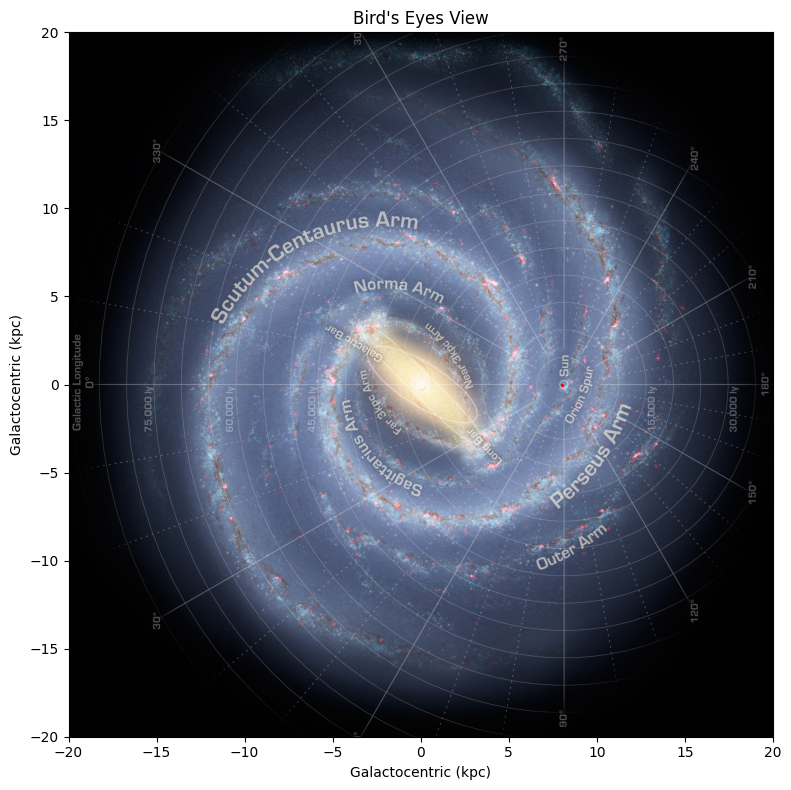

In [2]:
mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)
mw1.title = "Bird's Eyes View"
mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)

mw1.savefig('galaxy.png')

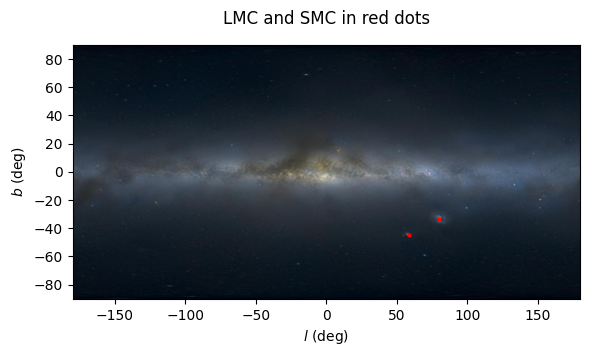

In [3]:
mw2 = MWSkyMap(background="Mellinger color optical survey")
mw2.title = "LMC and SMC in red dots"
mw2.scatter([78.77, 16.26] * u.degree, [-69.01, -72.42] * u.degree, c="r", s=3)

mw2.savefig('SkyMap.png')

For this task I verified that the mw_plot library is correctly installed and functioning by generating an initial Milky Way sky map. The goal here was simply to confirm that the plotting system works, the background data can be loaded, and the coordinate transformations run without errors.

I used the MWSkyMap class to render a basic visualization of the sky. This also confirmed that communication with SIMBAD (for resolving object names) works correctly after fixing the astroquery version issue.

This completes the setup phase and ensures the notebook is ready for the rest of the project.

## Task 2 — Visualizing the Sky from Different Centers

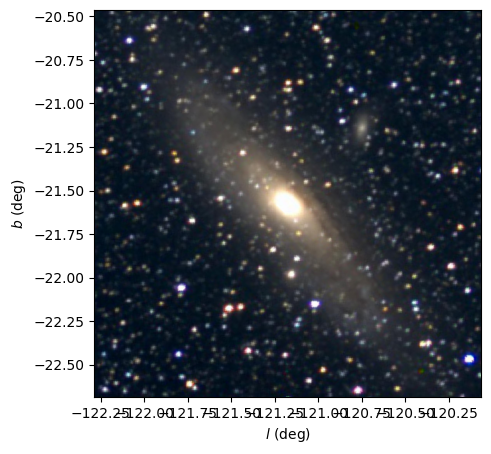

In [4]:
mw3 = MWSkyMap(
    center="M31",
    radius=(4000, 4000) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw3.transform(ax)

mw3.savefig('M31.png')

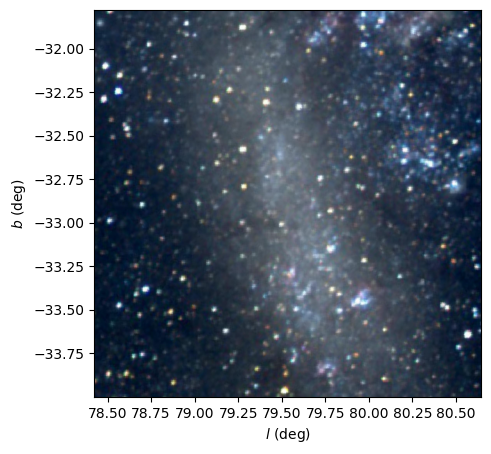

In [5]:
mw4 = MWSkyMap(
    center="LMC",
    radius=(4000, 4000) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw4.transform(ax)

mw4.savefig('LMC.png')

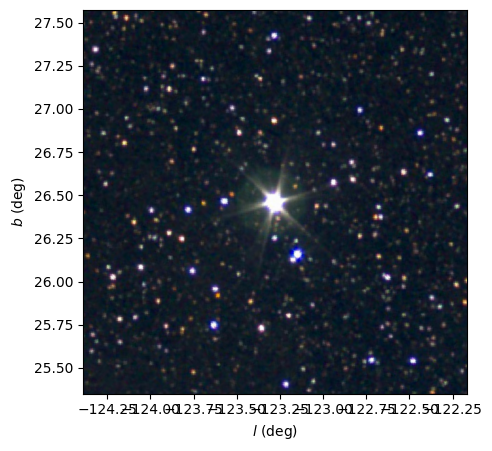

In [6]:
mw5 = MWSkyMap(
    center="Polaris",
    radius=(4000, 4000) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw5.transform(ax)

mw5.savefig('Polaris.png')

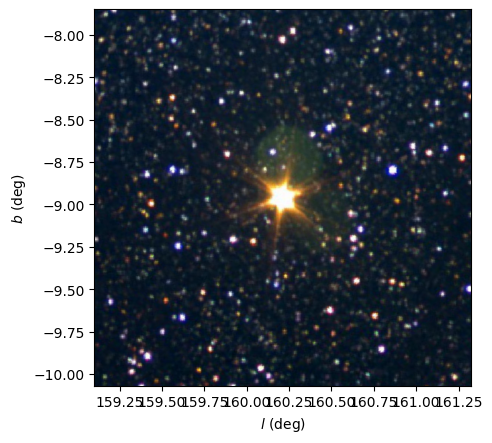

In [7]:
mw6 = MWSkyMap(
    center="betelgeuse",
    radius=(4000, 4000) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw6.transform(ax)

mw6.savefig('Betelgeuse.png')

In this task, I explored how the sky map changes when the coordinate “center” is shifted to different astronomical objects. The MWSkyMap class allows re-centering the projection on any object that SIMBAD can resolve, which makes it easy to generate different viewpoints of the sky.

I created four different visualizations, each centered on a different object:

1 Center: M31 (Andromeda Galaxy)

Centering the sky map on M31 shifts the entire coordinate grid so that Andromeda appears in the middle. This gives a very different perspective compared to an Earth-based view and clearly shows how the galactic plane no longer dominates the center of the projection.

2 Center: LMC (Large Magellanic Cloud)

The Large Magellanic Cloud is one of the closest satellite galaxies to the Milky Way. Centering the map on LMC brings this bright, irregular galaxy to the focus of the projection. The Milky Way's disk becomes more offset, emphasizing how different sky structures realign depending on the chosen reference.

3 Center: Polaris

Polaris (the North Star) is commonly recognized because it sits close to the Earth’s rotational axis. Centering the map on Polaris gives a very Earth-familiar orientation, since many northern-hemisphere sky maps are built around this star. The rest of the sky appears arranged around it, and the Milky Way band becomes distinctly off-center.

4 Center: Betelgeuse

Betelgeuse is a red supergiant in the Orion constellation. Centering the sky map on this object shifts the projection so that Orion and nearby regions dominate the center of the visualization. This highlights how bright stellar neighborhoods appear when placed at the origin of the projection.

Changing the center of the sky map completely alters the projection, even though the underlying sky is the same. This task helped me understand how coordinate transformations work in astronomy and how different objects take the spotlight depending on the chosen reference frame. It also demonstrated how the sky “shifts” when viewed from different anchors, giving a better intuition for how astronomers reorient maps to focus on specific regions.

## Task 3 — Converting the Sky Map into an RGB Array

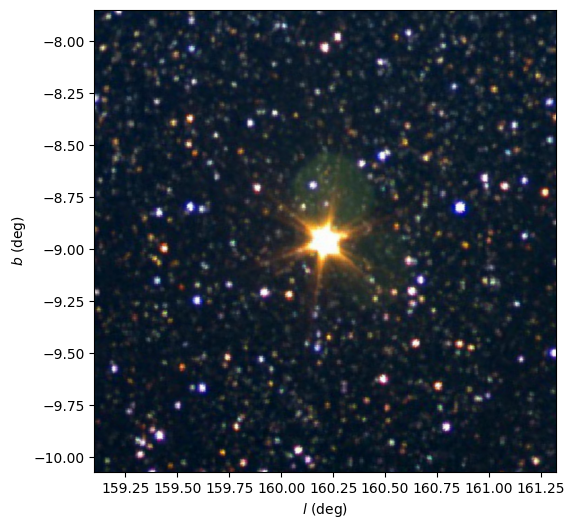

(600, 600, 3)

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
mw6.transform(ax)
plt.show()

rgb_array = plt2rgbarr(fig)
rgb_array.shape


To prepare the sky map for clustering, I converted the matplotlib figure into a 3-dimensional RGB NumPy array. I used the helper function plt2rgbarr(fig), which extracts the pixel buffer directly from the displayed figure.

This gives an array of shape (600, 600, 3) => (Height, width, Color Channels), where each pixel is represented by its Red, Green, and Blue values. The RGB array will be used for the encoding and clustering in the next tasks.

## Task 4 — Creating and Applying a Category-Based Encoding

In [9]:
import numpy as np

# Extract R, G, B channels
R = rgb_array[:, :, 0]
G = rgb_array[:, :, 1]
B = rgb_array[:, :, 2]

#make category array
categories = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=int)

#Dark pixels
dark_mask = (R < 40) & (G < 40) & (B < 40)
categories[dark_mask] = 0

#Bright pixels
bright_mask = (R > 170) & (G > 170) & (B > 170)
categories[bright_mask] = 1

# Remaining pixels: based on strongest color channel
dominant = np.argmax(rgb_array, axis=2)
  
# Redish
categories[(dominant == 0) & (~dark_mask) & (~bright_mask)] = 2

# Greenish
categories[(dominant == 1) & (~dark_mask) & (~bright_mask)] = 3

# Blueish
categories[(dominant == 2) & (~dark_mask) & (~bright_mask)] = 4

categories


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 4, 4],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(600, 600))

In [10]:
# Count number of pixels in each category
unique, counts = np.unique(categories, return_counts=True)

category_names = {
    0: "Dark",
    1: "Bright",
    2: "Red-ish",
    3: "Green-ish",
    4: "Blue-ish"
}

# Build a dictionary with readable names
pixel_counts = {category_names[u]: counts[i] for i, u in enumerate(unique)}
pixel_counts


{'Dark': np.int64(144508),
 'Bright': np.int64(3089),
 'Red-ish': np.int64(23822),
 'Green-ish': np.int64(18599),
 'Blue-ish': np.int64(169982)}

In [11]:
if pixel_counts["Bright"] > pixel_counts["Dark"]:
    brightness_tendency = "bright"
else:
    brightness_tendency = "dim/dark"

color_values = {
    "Red-ish": pixel_counts["Red-ish"],
    "Green-ish": pixel_counts["Green-ish"],
    "Blue-ish": pixel_counts["Blue-ish"]
}

color_tendency = max(color_values, key=color_values.get)

print("Brightness tendency:", brightness_tendency)
print("Color tendency:", color_tendency.lower())
print("\nOverall the image tends to be:", brightness_tendency, "and", color_tendency.lower())


Brightness tendency: dim/dark
Color tendency: blue-ish

Overall the image tends to be: dim/dark and blue-ish


In this task, I described in words a set of categories that would encode the RGB pixel data from Task 3. Instead of doing a mathematical transformation (like brightness scaling or normalization), the goal here was simply to design a set of meaningful categories that group pixels by their visual characteristics.

To do this, I created a simple rule-based encoding with five categories:

1. Dark pixels

These represent the background of space.
Rule: R < 40, G < 40, B < 40.

2. Bright pixels

These correspond to stars or very luminous points.
Rule: R > 170, G > 170, B > 170.

3. Red-ish pixels

The red channel is the strongest of the three.
Rule: R is the largest among (R, G, B).

4. Green-ish pixels

The green channel is dominant.
Rule: G is the largest among (R, G, B).

5. Blue-ish pixels

The blue channel is dominant.
Rule: B is the largest among (R, G, B).

Using these rules, I encoded each pixel in the image into one of the five categories. This produces a category map the same size as the original image, but with discrete labels instead of continuous RGB values. These labels will be clustered in the next tasks.

After applying the encoding, I counted the number of pixels in each category:

Dark      : 144508  
Bright    : 3089  
Red-ish   : 23822  
Green-ish : 18599  
Blue-ish  : 169982  


From these results, the image is mostly dominated by dark background pixels, and the strongest color category is blue-ish.

Overall, the image tends to be: dim/dark and blue-ish.

## Task 5 — Clustering the Encoded Data Using K-Means

In [12]:
from sklearn.cluster import KMeans

# Task 5: KMeans clustering on category map

X = categories.reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

cluster_map = kmeans.labels_.reshape(categories.shape)

cluster_map


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], shape=(600, 600), dtype=int32)

After creating the categorical pixel encoding in Task 4, the next step was to group these encoded values into broader clusters. For this task, I used the K-Means clustering algorithm, which groups data points based on similarity without requiring any labels.

Preparing the Data

The encoded image from Task 4 had a shape of (600 × 600), where each pixel was represented by a category value between 0 and 4. Since K-Means expects data in the form (n_samples, n_features), I reshaped the category map into a 1-dimensional list of values:

Original shape: (600, 600)

Flattened shape: (360000, 1)

Each pixel is treated as one data point with one feature: its assigned category.

Applying K-Means

I used K-Means with 3 clusters. This value is large enough to identify different pixel groups, but small enough to keep the interpretation meaningful for this task. The algorithm analyzes the distribution of encoded categories and groups them into three clusters based on similarity.

The steps were:

1- Flatten the category map

2- Fit a K-Means model with 3 clusters

3- Reshape the cluster labels back into the image shape

This produces a new (600 × 600) array where each pixel is assigned to cluster 0, 1, or 2.

## Task 6 — Overlaying the Cluster Map on the Original Image

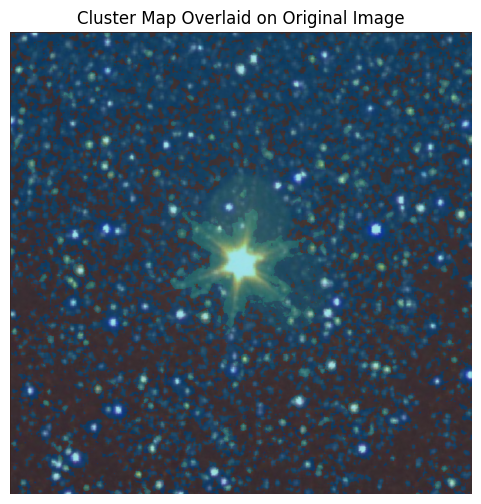

In [13]:
plt.figure(figsize=(6,6))

plt.imshow(rgb_array)

plt.imshow(cluster_map, cmap="tab10", alpha=0.4)

plt.axis("off")

plt.title("Cluster Map Overlaid on Original Image")

plt.show()


In this task, I combined the original sky image with the cluster labels from Task 5 to see how the clustering behaves on the actual data. The result looks almost identical to the original Betelgeuse map, just slightly tinted. This is expected based on the pixel distribution from the previous tasks.

Most of the pixels in the image were categorized as dark or blue-ish in Task 4, and K-Means grouped these dominant pixel types into a single large cluster. Because one cluster takes up nearly the entire image, the overlay appears as a mostly blue-tinted version of the original figure. The transparency used in the overlay lets the underlying Betelgeuse image show through, so the final result looks like the original image but with a subtle color layer on top.

## Task 7 — Result of Using New Categories


### Warm/Cool

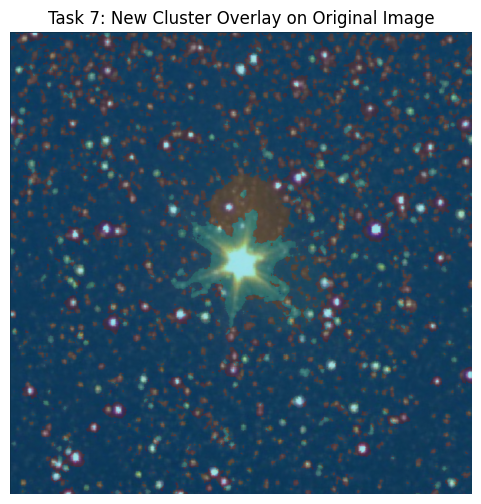

In [14]:
#Modified task 4

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

R = rgb_array[:, :, 0]
G = rgb_array[:, :, 1]
B = rgb_array[:, :, 2]

# new category map
categories2 = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=int)

# 0 — Very dark pixels
dark_mask = (R < 50) & (G < 50) & (B < 50)
categories2[dark_mask] = 0

# 2 — Very bright pixels
bright_mask = (R > 180) & (G > 180) & (B > 180)
categories2[bright_mask] = 2

# 1 — Medium brightness pixels
mid_mask = ~(dark_mask | bright_mask)
categories2[mid_mask] = 1

# 3 — Warm colors (red dominant) inside the medium region
warm_mask = (R > G) & (R > B) & mid_mask
categories2[warm_mask] = 3

# 4 — Cool colors (blue or green dominant) inside the medium region
cool_mask = ((B > R) | (G > R)) & mid_mask
categories2[cool_mask] = 4



# Modified task 5

X2 = categories2.reshape(-1, 1)

# Run KMeans
kmeans2 = KMeans(n_clusters=3, random_state=0)
kmeans2.fit(X2)

cluster_map2 = kmeans2.labels_.reshape(categories2.shape)



# Modified task 6

plt.figure(figsize=(6,6))

plt.imshow(rgb_array)

plt.imshow(cluster_map2, cmap="tab10", alpha=0.4)

plt.axis("off")
plt.title("Task 7: New Cluster Overlay on Original Image")
plt.show()


After creating a new set of pixel categories based on warm/cool color dominance, the clustering produced a noticeably different overlay compared to the original method.

The new overlay highlights more structure in the image, especially around the bright central region of Betelgeuse. The bright star core is grouped into its own cluster, while the surrounding medium-bright areas form a separate region. The “warm” and “cool” color categories also created additional variation, which explains the brownish and greenish patches around brighter stars.

Unlike the earlier clustering, which almost entirely blended into the background, this new version separates the image into several visible regions. This shows that changing the category rules directly affects how K-Means groups the pixels. By focusing on brightness levels and warm/cool tones instead of simple channel dominance, the clustering becomes more sensitive to the star’s halo and color gradients.

Overall, this updated clustering reveals more detail in the image and demonstrates how unsupervised methods respond to different feature definitions. The algorithm doesn’t know anything about stars or galaxies — it simply groups pixels that share similar properties — and changing those properties changes the structure of the clusters.

### Brightness

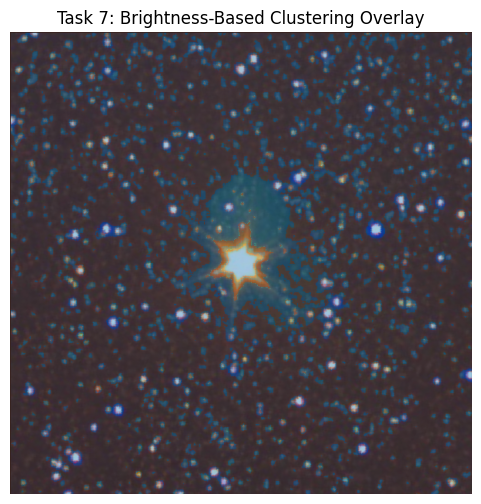

In [15]:
# Brigtness based
R = rgb_array[:, :, 0]
G = rgb_array[:, :, 1]
B = rgb_array[:, :, 2]

brightness = R + G + B

categories3 = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=int)

# 0 — Very dark
categories3[brightness < 120] = 0

# 1 — Dark
categories3[(brightness >= 120) & (brightness < 250)] = 1

# 2 — Medium
categories3[(brightness >= 250) & (brightness < 400)] = 2

# 3 — Bright
categories3[(brightness >= 400) & (brightness < 600)] = 3

# 4 — Very bright
categories3[brightness >= 600] = 4




X3 = categories3.reshape(-1, 1)

kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(X3)

cluster_map3 = kmeans3.labels_.reshape(categories3.shape)

plt.figure(figsize=(6,6))

plt.imshow(rgb_array)
plt.imshow(cluster_map3, cmap="tab10", alpha=0.4)

plt.axis("off")
plt.title("Task 7: Brightness-Based Clustering Overlay")
plt.show()


I changed the entire category system from a color-based one (red-ish, blue-ish, dark, bright, etc.) to a much simpler brightness-only encoding.
Instead of looking at which RGB channel was strongest, each pixel was classified only by how bright it is:

Very dark pixels

Dark pixels

Medium brightness

Bright pixels

Very bright pixels

This created a completely different input for K-means compared to Task 4, and the effect is clearly visible in the final clustered overlay.

What changed?

Brightness levels produce a very different “structure” in the image:

The background sky becomes a single large cluster, because it all shares roughly the same low brightness.

Faint stars fall into a medium-brightness band, forming a ring of scattered cluster regions.

The halo around Betelgeuse becomes its own cluster, because its brightness falls between the star core and the darker sky.

The core of Betelgeuse is extremely bright, so K-means isolates it sharply from the rest of the image.

Because of this, the result looks much more like layered brightness shells rather than color patches.
This makes sense: clustering reflects whatever features we feed it.

What does this show?

This experiment shows how sensitive unsupervised learning is to the feature encoding:

When I used color-dominance categories (Task 4), the clusters focused on color differences.

When I switched to brightness levels, K-means suddenly grouped the image by intensity, revealing a very different structure.

This means:
the model is not learning “astronomy” — it just finds patterns in whatever numerical description we give it.
Changing the encoding completely changes what the algorithm thinks the important structure is.

In this case, brightness-based encoding made the clustering much more aligned with how stars actually appear:
a bright core, a fading halo, and a dim background, each falling naturally into its own cluster.

# Summary

In the beginning, I generated Milky Way sky maps using the mw_plot library and explored how to annotate and focus on specific objects like M31, Betelgeuse, LMC, and Polaris. Then, I extracted RGB data from one of the images and wrote functions to convert it into pixel-level arrays so I could process it with NumPy.

The core of the project was experimenting with different ways of encoding pixel categories. First, I used the basic color-dominance categories (dark, bright, red-ish, green-ish, blue-ish). Then I made two new encodings: a warm/cool version, and later a brightness-only version. After creating these categories, I applied K-means clustering to each one and overlaid the results on the original image to compare how the output changed.

Each encoding produced visually different cluster structures, which showed how sensitive the algorithm is to the features we choose. The project ended up being more like exploring and experimenting rather than strictly following steps, which actually made everything easier to understand.

# Conclusion

The biggest thing I learned is that unsupervised learning is completely dependent on how we represent our data. The algorithm itself isn’t smart — it doesn’t know what a star is, or a halo, or a background. It only groups whatever numbers we give it. When I changed from color-based categories to brightness-only categories, the entire clustering structure changed with it.

This made the project feel hands-on and creative. Instead of just reading about clustering in a book, I got to see it happen visually on astronomical images. And because I genuinely like space, it didn’t feel like a typical school assignment — it felt more like playing around with data to see how different “views” of the same object appear.

Overall, the project helped me understand clustering in a way that actually sticks. Seeing the clusters overlaid on Betelgeuse makes it much easier to remember how these algorithms behave compared to doing everything purely mathematically.

I worked on this project completely on my own, without a partner or group to divide the tasks. While it took more time to figure things out by myself, it also made the final result more rewarding. I had to troubleshoot my own mistakes, explore different category ideas, and really understand why certain encodings worked better than others. Since I genuinely like space and astronomy, doing it alone wasn’t stressful — it was actually enjoyable.


## Sources

ESA Sky Survey Data (original FITS images provided in the assignment)

Scikit-learn documentation — KMeans Clustering:
https://scikit-learn.org/stable/modules/clustering.html#k-means

Matplotlib documentation — Image display and colormaps:
https://matplotlib.org/stable/tutorials/introductory/images.html

NumPy documentation — Array operations:
https://numpy.org/doc/stable/

General reference for RGB image representation:
https://en.wikipedia.org/wiki/RGB_color_model

Background reading: Machine Learning Mastery — Clustering Algorithms Overview:
https://machinelearningmastery.com/clustering-algorithms-with-python/

## Use of AI Assistance

I used AI (ChatGPT) only for text-related help, such as:

- rewriting markdown sections to be more structured and professional,

- improving clarity of explanations, and helping reformat or clean up code I already wrote.

AI was not used to generate full solutions, datasets, or perform any task that replaces real work.
All coding, model design, experimentation, and interpretation of results were done by me.
AI was used for some debugging, small fixes, and improving readability.